## Import libraries

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import pywt

## Import Dataset

In [3]:
data = pd.read_excel("dataset/dataset.xlsx")
display(data.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3


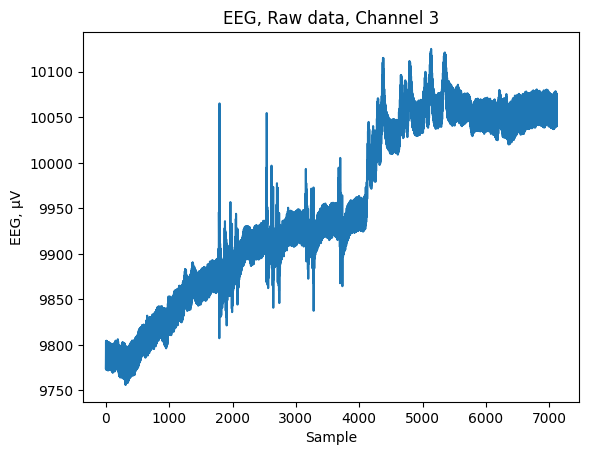

In [6]:
# select the data from the third channel
channel = 2
channel_data = data.iloc[:, channel]
# convert from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts µV
channel_data = round(1000000*4.5*(channel_data/16777215),2)

# plot the EEG data
plt.plot(channel_data)
plt.title("EEG, Raw data, Channel " +str(channel + 1))
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data. 

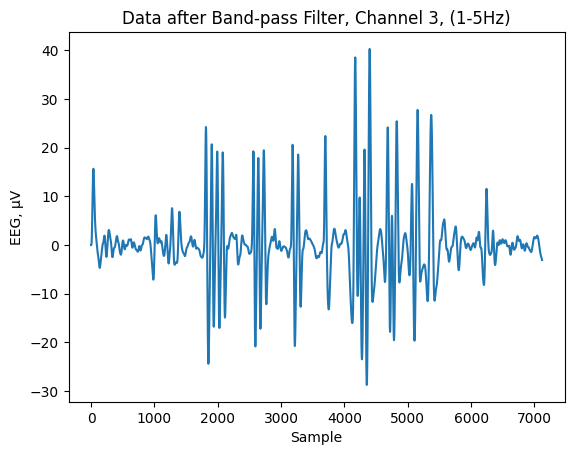

In [7]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 5  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Data after Band-pass Filter, Channel " +  str(channel+1) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Frequency analysis

Frequency analysis for EEG is a fundamental technique that unveils the distribution of different frequency components within the brain's electrical activity. This analysis involves the transformation of EEG signals from the time domain to the frequency domain, typically using the Fast Fourier Transform (FFT) algorithm. This transformation allows us to observe the intensity and prevalence of specific frequency bands, such as delta (0.5-4 Hz), theta (4-8 Hz), alpha (8-13 Hz), beta (13-30 Hz), and gamma (30-100 Hz) waves.

Each frequency band corresponds to distinct neural processes and cognitive states. For instance, delta waves are associated with deep sleep and unconsciousness, while alpha waves often indicate relaxed wakefulness. Beta waves are linked to active cognition and alertness, while gamma waves are connected to high-level information processing. Frequency analysis helps identify anomalies or irregularities in these patterns, aiding in the diagnosis of neurological conditions like epilepsy, sleep disorders, and cognitive impairments.

### Fast Fourier Transform (FFT)

FFT is a widely used method in signal processing and is particularly valuable in the field of neurophysiology for studying the frequency components present in EEG signals.

**Positive**

*   Frequency Representation: EEG signals consist of complex patterns of neural oscillations at different frequencies. FFT breaks down these signals into their constituent frequency components, revealing the dominant frequencies present in the data.

* Feature Extraction: FFT generates a frequency spectrum that can be used for feature extraction. Different frequency bands (delta, theta, alpha, beta, gamma) are associated with distinct cognitive and neural processes, enabling the extraction of relevant features for analysis.

* Brain Rhythms: EEG signals are characterized by rhythmic patterns linked to brain functions. FFT enables the identification and quantification of these rhythmic components, aiding in the study of brain states and processes.

* Event-Related Potentials (ERPs): FFT can be applied to segmented EEG epochs to examine event-related potentials, revealing time-locked neural responses to specific stimuli or events in the frequency domain.

* Spectral Analysis: FFT provides power spectral density estimates, helping to analyze the distribution of signal power across different frequency bands and their variations over time or experimental conditions.

* Artifact Detection: FFT can help in detecting and addressing artifacts in EEG data. Artifacts often appear as broadband frequency components, making them distinguishable from genuine neural oscillations.

* Temporal Resolution: While EEG has excellent temporal resolution, it lacks frequency-specific information. FFT adds frequency specificity while preserving the time information, offering a comprehensive view of EEG signals.

**Negative**

*   Temporal Resolution: FFT sacrifices temporal resolution to provide frequency information. This can lead to a loss of information regarding rapid changes and dynamic interactions between neural oscillations, which are crucial for understanding certain cognitive processes.

*  Frequency Leakage: FFT assumes that signals are periodic and stationary, which may not hold true for EEG data. This can result in "frequency leakage," where spectral energy can spread across adjacent frequency bins, making it challenging to accurately isolate specific frequency components.

*  Windowing Effects: Applying FFT to short segments of EEG data, a common practice for event-related analysis, introduces windowing effects that can distort frequency representations, particularly for high-frequency oscillations.

*  Non-Stationarity: EEG signals can exhibit non-stationarity, where frequency content changes over time. FFT assumes stationary signals, which can lead to misinterpretations of dynamic changes in neural activity.

*  Artifact Influence: EEG signals often contain artifacts (e.g., eye blinks, muscle activity) that can introduce spurious frequency components. FFT might not effectively separate these artifacts from genuine neural oscillations.

*  Choosing Frequency Bands: Dividing EEG signals into predefined frequency bands using FFT might not capture individual variability in frequency ranges and can lead to arbitrary or oversimplified interpretations.

**How it works**  

FFT is a mathematical algorithm that converts time-domain EEG signals into the frequency domain. It does this by breaking down the EEG data into its constituent sinusoidal frequency components, revealing the strength of each frequency's presence in the signal. This process helps identify dominant frequencies and their distribution, offering insights into the underlying neural oscillations present in the EEG data.

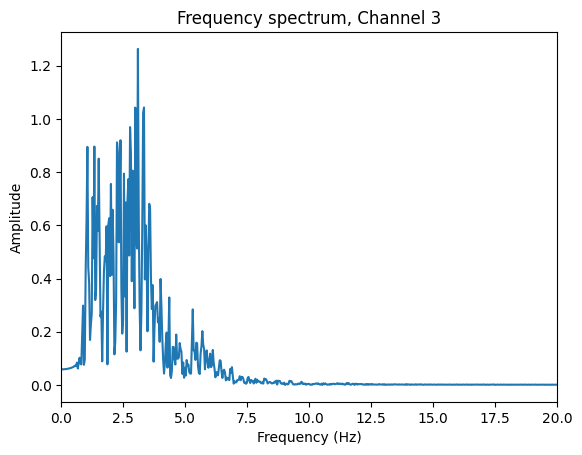

In [8]:
data_len = len(channel_data_bp_filtered)  # number of observations
fourier_transform = np.fft.fft(channel_data_bp_filtered)  # compute FFT
fourier_transform = fourier_transform / data_len  # normalize values
fourier_transform = fourier_transform[:int(data_len/2)]  # take half of the data

time_period = data_len / fps  # time period of the signal
values = np.arange(int(data_len/2))  # x-axis values up to Nyquist frequency
frequencies = values / time_period  # x-axis values in Hz

# plot the frequency spectrum
plt.plot(frequencies, abs(fourier_transform))
plt.title("Frequency spectrum, Channel " + str(channel+1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0, 20])
plt.show()

### Wavelet transform

Wavelet transform is another useful technique for dimensionality reduction in EEG data. It is particularly effective when dealing with time-frequency analysis, allowing the extraction of relevant time-frequency features from EEG signals.

**Positive**

* Time-Frequency Localization: Wavelet transform provides a localized representation of frequency content over time. This enables the identification of transient changes in neural activity and frequency modulation that might be missed by methods focused solely on time or frequency.

* Multiresolution Analysis: Wavelet transform decomposes EEG signals into different scales, revealing details at various levels. This allows for a selective representation of signal components, effectively highlighting relevant patterns while reducing noise.

* Adaptation to Non-Stationarity: EEG signals often exhibit non-stationarity, with frequency characteristics changing over time. Wavelet's variable-sized window can adapt to these changes, ensuring accurate representation of dynamic neural processes.

* Sparse Representation: In wavelet decomposition, only a subset of coefficients is significant, resulting in a sparse representation. This sparsity can be leveraged for efficient dimensionality reduction while preserving essential signal characteristics.

* Artifact Removal: Wavelet denoising techniques can effectively remove noise and artifacts from EEG data, enhancing the signal-to-noise ratio and improving the quality of data used for subsequent analyses.

* Visualization: Wavelet scalograms provide a visual representation of time-frequency dynamics, aiding in the identification of patterns and changes in neural oscillations.

* Customization: Wavelet analysis offers a range of wavelet functions and scales that can be tailored to the specific characteristics of EEG data and research questions, enhancing flexibility and adaptability.

**Negative**

* Feature Extraction Overload: Wavelet coefficients generated from different scales can result in a large number of features. If not managed carefully, this abundance of features can lead to overfitting and reduced interpretability.

* Subjectivity in Wavelet Selection: The choice of wavelet function and decomposition levels can be subjective and influence the outcomes. Different choices might yield varying results, leading to difficulties in reproducibility.

* Loss of Temporal Detail: While Wavelet transform captures time-frequency information, it might not retain fine-grained temporal details as effectively as time-domain methods. This could be a limitation when preserving precise timing is crucial.

* Non-Linear Relationships: Wavelet transform assumes linear relationships between the different scales and levels of EEG data, which might not hold true in all cases. This could lead to oversimplification of complex neural interactions.

* Choice of Scaling Functions: Different wavelet functions are suited for different types of signals. Selecting an inappropriate wavelet could result in a poor representation of the EEG data, leading to suboptimal dimensionality reduction.

**How it works**  

Wavelet transform is a mathematical technique that analyzes EEG data by decomposing it into different frequency components over time. It involves using a set of wavelet functions, which are like filters of varying scales, to capture both the time and frequency characteristics of the data. By applying these wavelets, the original EEG signal is transformed into a representation where different scales reveal different frequency information. This approach is useful for understanding how frequencies change over time, which is important in capturing the dynamic nature of EEG signals.

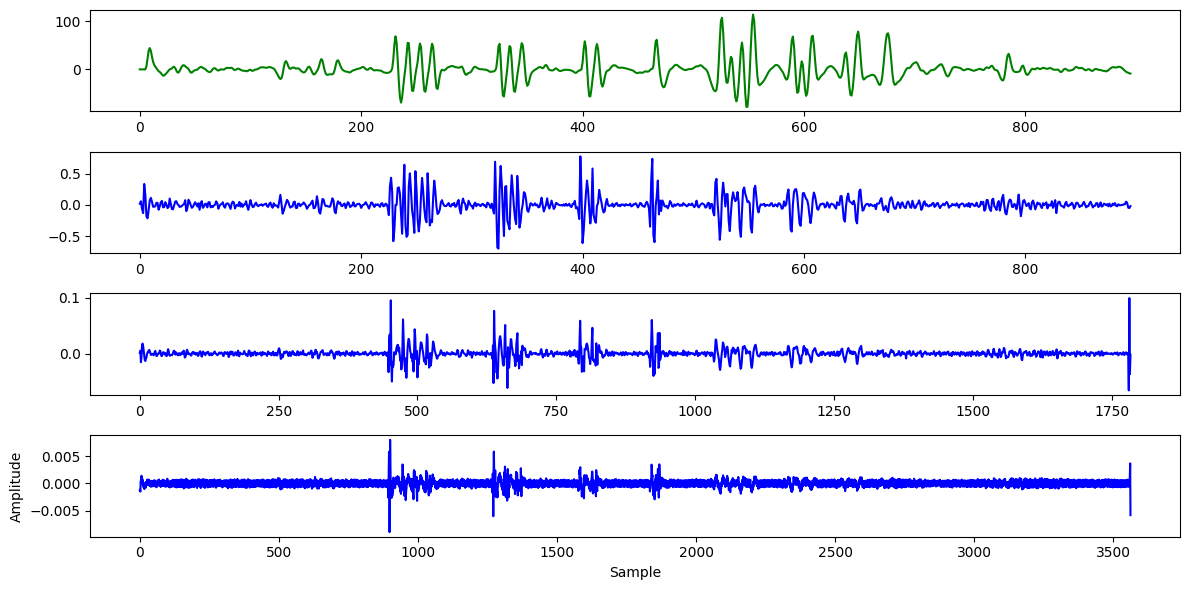

In [9]:
# define wavelet function and decomposition level
wavelet = 'db4'
level = 3

# perform wavelet decomposition
coeffs = pywt.wavedec(channel_data_bp_filtered, wavelet, level=level)

# plot wavelet coefficients
fig, axs = plt.subplots(level+1, 1, figsize=(12, 6))

# plot approximation coefficients
axs[0].plot(coeffs[0], 'g')
axs[3].set_ylabel('Amplitude')

# plot detail coefficients
for i, detail_coeffs in enumerate(coeffs[1:]):
    axs[i+1].plot(detail_coeffs, 'b')

axs[-1].set_xlabel('Sample')
plt.tight_layout()
plt.show()